# 灰度直方图（Gray Histogram）

在数字图像处理中，灰度直方图是一种计算代价非常小但却很有用的工具，它概括了一幅图像的灰度级信息，它用来描述每个灰度级在图像矩阵中的像素个数或者占有率，或者出现频率。

通过直方图，我们可以很快知道一个灰度图片中有效数据的大概范围，可以通过一些简单的线性计算，将我们感兴趣的数据重新编辑到新的图片中，也可以调节一张照片的曝光量，某些教科书上称这种做法叫对比度进行调节。

当然，如果配合神经元网络，我们也可以对一些黑白照片重新上色。当然这些都是比较高阶的技巧了。
 
直方图调整有几种常用的方法，如线性变换、分段线性变换、伽马变换、直方图正规化、直方图均衡化、局部自适应直方图均衡化、图像翻转等，这些方法的计算代价较小，但是却产生了较为理想的效果。

# 直方图的计算方法

![在这里插入图片描述](https://img-blog.csdnimg.cn/2020112323385583.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3BvaXNvbmNocnk=,size_16,color_FFFFFF,t_70#pic_center)

我又把这张图拿了出来，直方图的计算方式，其实就是从上到下，从左到右一个一个像素进行统计。所以假设我们对林肯的照片进行分析，绘制这张照片的直方图，那么在X轴的方向，就是强度信息，也就是灰度值 $[0, 255]$，而它的Y轴方向，就是频率信息，或者说是各像素点值的出现率。

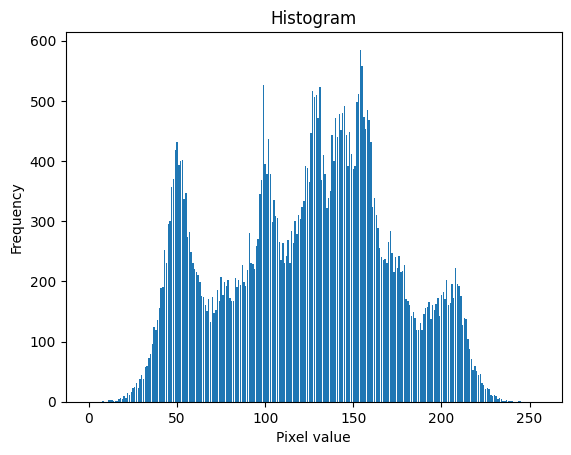

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

BASE_DIR = "/opt/images/DIPRawImageDataset/DIP3E_CH03_Original_Images/DIP3E_Original_Images_CH03"

def calculate_hist(img):
    # create a matrix to hold histogram information
    histogram = np.zeros(256, dtype=np.uint64)

    # iterate each pixel
    row, col = img.shape
    for r in range(row):
        for c in range(col):
            histogram[img[r, c]] = histogram[img[r, c]] + 1

    # return to caller
    return histogram

# Read image
img = cv2.imread("/opt/images/lena.png", cv2.IMREAD_GRAYSCALE)

# Calculate histogram
histogram = calculate_hist(img)

# Plot histogram using bar chart
plt.bar(np.arange(256), histogram)
plt.title("Histogram")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.show()

# 简单的图像转换方法

## 线性变换 / 图像翻转（Image Nagatives）

线性变换，又或者叫图像翻转，通常被应用于X光照片这类图像的处理。**由于我们兴趣区域的数据多处于低密度区域，而这部分数据如果直接显示通常较难观察到（low intensity）**，例如X光来说，低密度的细节通常很难进行观察，而通过线性转换，则可以得到一些用肉眼不太容易注意到的细节。

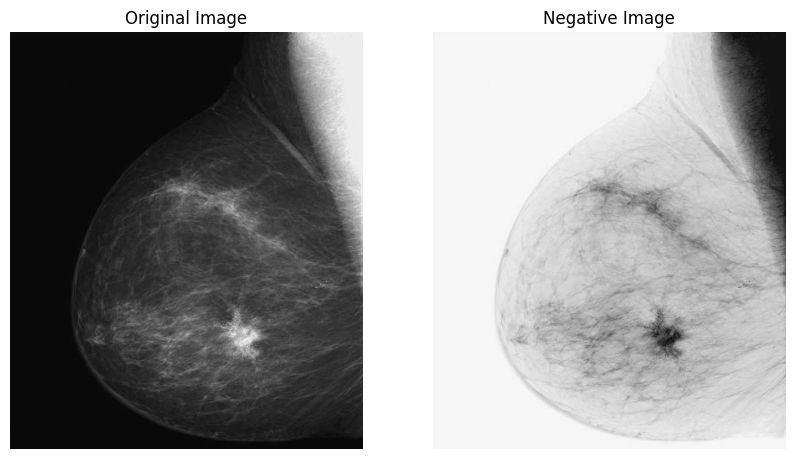

In [8]:
def image_negative(file: str):
    image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)

    negative_img = 255 - image.flatten()
    negative_img = negative_img.reshape(image.shape)
    return negative_img, image


# Read image
negative, origin = image_negative(os.path.join(BASE_DIR, "Fig0304(a)(breast_digital_Xray).tif"))

# Show image and negative image
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(origin, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(negative, cmap='gray')
plt.title("Negative Image")
plt.axis('off')
plt.show()




比如这张对乳腺的X光照片，转换后的右侧图片中黑色斑块的位置，可能预示患者已经有了肿块，可能需要进一步的细致检查。假设图像的灰阶为$[0, 255]$这个范围，那么它的线性转换计算方式可以简单的表示为：

$$ I_c = 255 - I_o $$

其中$I_c$表示为转换后的图像灰阶，$I_o$表示为原始图像灰阶。在冈萨雷斯的教材上，这个公式表示为：$s = L - 1 - r$，本质上是一样的。

## 对数变换（Log Transformation）

由于线性变化，正如其名字线性的，所以如果很多重要的数据都挤压在低密度数据区间时，直接进行线性变化也很难看出图像的特征，那么就通过对数的方式，不成比例的“放大”图像的细节。

$$ I_c = c \cdot log(1 + I_o) $$

其中 $c$ 是曲线放大系数，$(1+I_o)$ 的目的是把 log 曲线向左移1个单位。

![在这里插入图片描述](https://img-blog.csdnimg.cn/20201128202141224.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3BvaXNvbmNocnk=,size_16,color_FFFFFF,t_70#pic_center)

放大系数并无固定要求，通常根据自己实际工作的需要来调试确定。

/tmp/ipykernel_267872/3664721427.py:4: RuntimeWarning: divide by zero encountered in log
  log_trans = 10 * np.log(1 + image)
/tmp/ipykernel_267872/3664721427.py:5: RuntimeWarning: invalid value encountered in cast
  log_trans = np.uint8(log_trans)


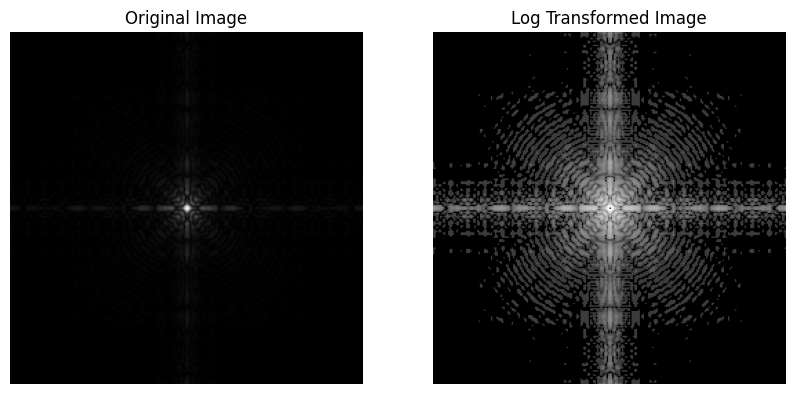

In [9]:
def log_transform(file: str):
    image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)

    log_trans = 10 * np.log(1 + image)
    log_trans = np.uint8(log_trans)
    return log_trans, image

# Read image
log, origin = log_transform(os.path.join(BASE_DIR, "Fig0305(a)(DFT_no_log).tif"))

# Show image and log transformed image
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(origin, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(log, cmap='gray')
plt.title("Log Transformed Image")
plt.axis('off')
plt.show()

## Gamma变换（Power-Law Transformation）

Gamma函数实际上就是幂函数，其公式为：

$$
I_c = c \cdot I{_o}^\gamma
$$

不同的gamma值，会输出不同的映射曲线，由于我们通常只使用其第一象限内的映射，且把$[0,255]$的灰阶强度，归一化后控制在$[0,1]$这个区间

![在这里插入图片描述](https://img-blog.csdnimg.cn/202011282048058.jpg?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3BvaXNvbmNocnk=,size_16,color_FFFFFF,t_70#pic_center)

所以实际上的转换效果是这样：

![在这里插入图片描述](https://img-blog.csdnimg.cn/20201128205301778.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3BvaXNvbmNocnk=,size_16,color_FFFFFF,t_70#pic_center)

**通过gamma变换，可以有效的纠正一张过曝或欠光的图片。从图中的曲线可以得知，如果要将一张欠光的照片调整到正常的样子，可以让 $\gamma < 1$。而对于一张过曝的照片，则可以让$\gamma > 1$，从而获得满意的效果。**

$c$ 通常为放大、缩小倍数，一般情况下，我们令其为1。

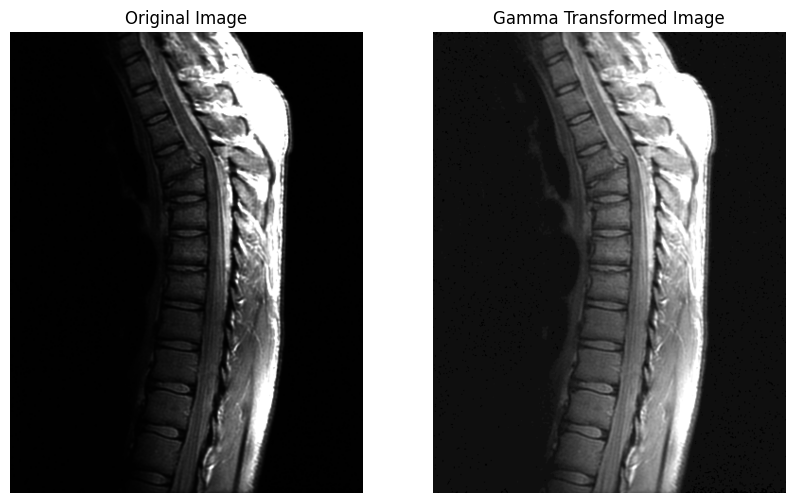

In [10]:
def gamma_transform(file: str, c, gamma):
    image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)

    # normalization the pixels
    float_image = image / 255.0

    # gamma transformation
    gamma = c * np.power(float_image, gamma)

    # denormalization
    gamma = np.uint8(255 * gamma)

    return gamma, image

# Read image
gamma, origin = gamma_transform(os.path.join(BASE_DIR, "Fig0308(a)(fractured_spine).tif"), 1, 0.5)

# Show image and gamma transformed image
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(origin, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(gamma, cmap='gray')
plt.title("Gamma Transformed Image")
plt.axis('off')
plt.show()
